### Importing The Libary Modules

In [2]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the Processes Data

In [ ]:
data_df = pd.read_csv('../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

### Processing the Data For Visualization

In [4]:

h2h = data_df[['raceId', 'driverId', 'driverFinalRank', 'driverName']].copy()    # Extracting The neccessary Features From The processes Data
 

h2h_merged = pd.merge(h2h, h2h, on='raceId', suffixes=('_A', '_B'))    # self_joining The data with Itself to create a pair of drivers
h2h_merged = h2h_merged[h2h_merged['driverId_A'] < h2h_merged['driverId_B']]   # removing The duplicates


h2h_merged['A_wins'] = (h2h_merged['driverFinalRank_A'] < h2h_merged['driverFinalRank_B']).astype(int)  # Creating a column for A Wins
h2h_merged['B_wins'] = (h2h_merged['driverFinalRank_A'] > h2h_merged['driverFinalRank_B']).astype(int)  # Creating  a column for B WIns

# create a summary table
h2h_summary = h2h_merged.groupby(['driverId_A', 'driverName_A', 'driverId_B', 'driverName_B']).agg(
    encounters=('raceId', 'count'),
    A_wins=('A_wins', 'sum'),
    B_wins=('B_wins', 'sum'),
    A_avgFinish=('driverFinalRank_A', 'mean'),
    B_avgFinish=('driverFinalRank_B', 'mean')
).reset_index()

# Calculate win ratios for each driver in the matchup.
h2h_summary['A_winRatio'] = h2h_summary['A_wins'] / h2h_summary['encounters']
h2h_summary['B_winRatio'] = h2h_summary['B_wins'] / h2h_summary['encounters']

h2h_summary['position_diff'] = h2h_summary['A_avgFinish'] - h2h_summary['B_avgFinish']


h2h_summary.head()

,driverId_A,driverName_A,driverId_B,driverName_B,encounters,A_wins,B_wins,A_avgFinish,B_avgFinish,A_winRatio,B_winRatio,position_diff
0,1,Lewis Hamilton,2,Nick Heidfeld,68,46,22,6.147059,8.911765,0.676471,0.323529,-2.764706
1,1,Lewis Hamilton,3,Nico Rosberg,188,123,65,5.781915,7.606383,0.654255,0.345745,-1.824468
2,1,Lewis Hamilton,4,Fernando Alonso,316,209,107,5.367089,8.750000,0.661392,0.338608,-3.382911
3,1,Lewis Hamilton,5,Heikki Kovalainen,112,86,26,6.973214,13.285714,0.767857,0.232143,-6.312500
4,1,Lewis Hamilton,6,Kazuki Nakajima,36,28,8,7.388889,13.083333,0.777778,0.222222,-5.694444


### Stacked Back Plot

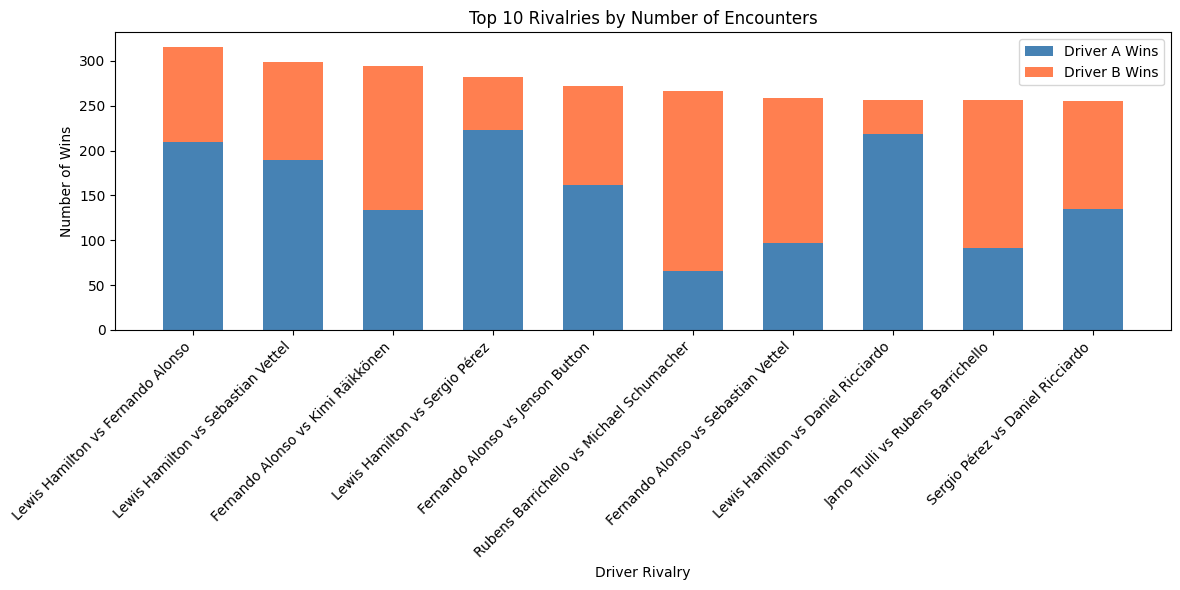

In [5]:

top10 = h2h_summary.sort_values(by='encounters', ascending=False).head(10)    # Sort head-to-head summary by number of encounters and pick top 10 rivalries.

top10['rivalry'] = top10.apply(lambda row: f"{row['driverName_A']} vs {row['driverName_B']}", axis=1)   # naming The rivalry for X- axis

plt.figure(figsize=(12,6))
bar_width = 0.6
  
plt.bar(top10['rivalry'], top10['A_wins'], bar_width, label='Driver A Wins', color='steelblue')   # plotting The  A Wins 
plt.bar(top10['rivalry'], top10['B_wins'], bar_width, bottom=top10['A_wins'], label='Driver B Wins', color='coral')  # plotting The B Wins 

plt.xticks(rotation=45, ha='right')
plt.xlabel("Driver Rivalry")
plt.ylabel("Number of Wins")
plt.title("Top 10 Rivalries by Number of Encounters")
plt.legend()
plt.tight_layout()
plt.show()


###### 

##### This Stacked box plot shows the data about the top 10 encountered Rivarlies and their win ratios The x- axis specifying The Rivalry and the Y-axis specifying the Number of Wins

###  Competitive Rivalries Scatter Plot

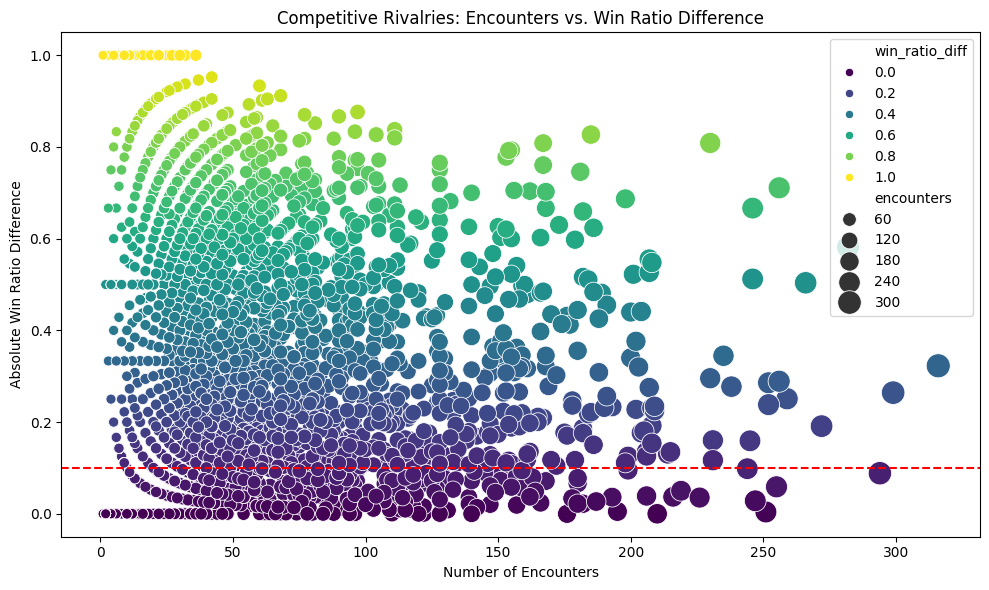

In [8]:
# Compute absolute difference in win ratios between the two drivers.
h2h_summary['win_ratio_diff'] = abs(h2h_summary['A_winRatio'] - h2h_summary['B_winRatio'])

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=h2h_summary,
    x='encounters',
    y='win_ratio_diff',
    hue='win_ratio_diff',
    palette='viridis',
    size='encounters',
    sizes=(50, 300),
)
plt.xlabel("Number of Encounters")
plt.ylabel("Absolute Win Ratio Difference")
plt.title("Competitive Rivalries: Encounters vs. Win Ratio Difference")
# Draw a reference line (e.g., win ratio difference less than 0.1 as highly competitive)
plt.axhline(0.1, color='red', linestyle='--', label='Highly Competitive (Diff < 0.1)')
plt.tight_layout()
plt.show()


##### This scatter plot shows each rivalry’s number of encounters (x-axis) against the absolute difference in win ratios (y-axis). A smaller difference in win ratios means the rivalry is more competitive.  
##### There are certain outliers in Short term encounters where certain drivers always win(indicated in yellow)  and Over long encounters most of the points fall below 0.2 win ratio difference which means over logn term both  wins almost mutally 

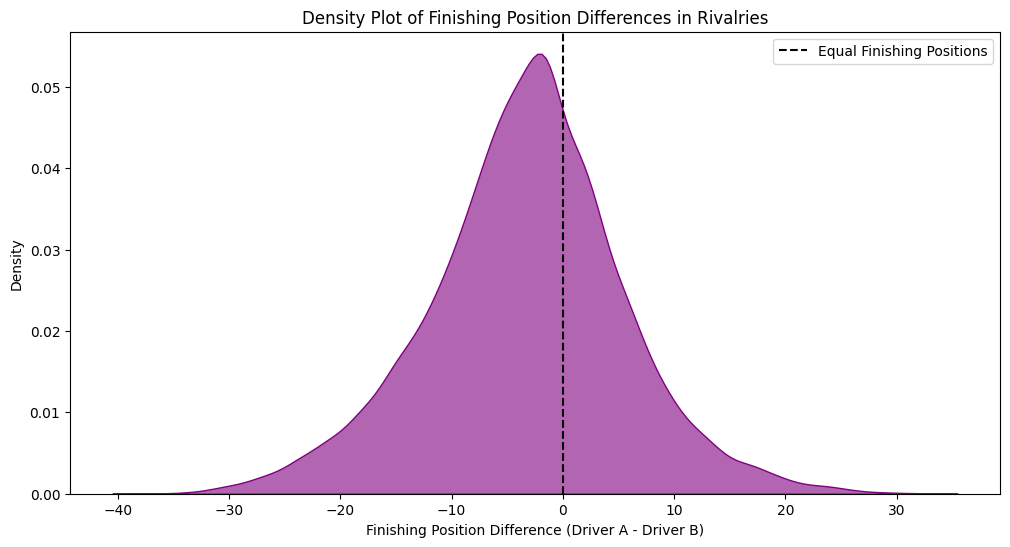

In [7]:
plt.figure(figsize=(12, 6))



h2h_summary['position_diff'] = h2h_summary['A_avgFinish'] - h2h_summary['B_avgFinish']

sns.kdeplot(
    data=h2h_summary,
    x='position_diff',
    fill=True,
    color='purple',
    alpha=0.6
)

plt.axvline(0, color='black', linestyle='--', label='Equal Finishing Positions')
plt.xlabel("Finishing Position Difference (Driver A - Driver B)")
plt.ylabel("Density")
plt.title("Density Plot of Finishing Position Differences in Rivalries")
plt.legend()
plt.show()


### Insights 

1. **Top 10 Rivalries by Number of Encounters:**
    - The bar plot shows the top 10 rivalries based on the number of encounters between drivers.
    - Lewis Hamilton vs Fernando Alonso, Lewis Hamilton vs Sebastian Vettel, and Fernando Alonso vs Kimi Räikkönen are among the most frequent rivalries.
    - The plot indicates the number of wins for each driver in these rivalries, with Lewis Hamilton having a significant number of wins in his top rivalries.

2. **Competitive Rivalries: Encounters vs. Win Ratio Difference:**
    - The scatter plot visualizes the number of encounters against the absolute difference in win ratios between drivers.
    - A smaller difference in win ratios indicates a more competitive rivalry.
    - The plot highlights that over long-term encounters, most rivalries have a win ratio difference below 0.2, suggesting mutual competitiveness.
    - Certain outliers in short-term encounters show drivers with consistently dominant performances.

3. **Density Plot of Finishing Position Differences in Rivalries:**
    - The density plot shows the distribution of finishing position differences between drivers in rivalries.
    - The plot is centered around zero, indicating that many rivalries have drivers finishing close to each other.
    - The black dashed line represents equal finishing positions, and the density around this line suggests competitive finishes.

